<a href="https://colab.research.google.com/github/Cal723/CSE-337-Labs/blob/main/lab11_MBRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Solving the mountaincar problem in 1 episode

In this lab, you will use a Gaussian Process (GP) model to learn the dynamics of the Mountain Car system.
Then, based on Lab 8, you will use MPPI or MPPI-Simplified to write the MPC loop that controls the vehicle.
The goal is to solve the Mountain Car problem in one episode.

## Provided code
* The following code implements a Gaussian Process regression model that predicts the next-state change (Δx) given [position, velocity, action].
* Example training data collected from random actions.



In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.8 MB/s eta 0:00:00


# Gaussian Process

In [16]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var


# Setup environment and collect initial data

In [17]:
import gymnasium as gym
# import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1.  Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
n_state = env.observation_space.shape[0]    # [position, velocity]
n_action = env.action_space.shape[0]        # 1 continuous action
n_output = 2                                # Δpos, Δvel


# --------------------------------------------------------------
# 2.  Collect initial random data
# --------------------------------------------------------------
data = {'X': [], 'Y': []}

obs, _ = env.reset(seed=0)
for _ in range(200):  # collect 500 transitions
    a = env.action_space.sample()  # random continuous action in [-1,1]
    x_next, r, term, trunc, _ = env.step(a)
    data['X'].append(np.concatenate([obs, a]))   # [pos, vel, action]
    data['Y'].append(x_next - obs)               # Δstate
    obs = x_next
    if term or trunc:
        obs, _ = env.reset()

X = np.array(data['X'])[::3]
Y = np.array(data['Y'])[::3]
print(f"Collected {len(X)} transitions.")


# --------------------------------------------------------------
# 3.  Train GP dynamics models
# --------------------------------------------------------------
gps = [GPManager(kernel='RBF', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")


Collected 67 transitions.
Trained GP for Δstate[0] with 67 samples.
Trained GP for Δstate[1] with 67 samples.


# Visualize collected data

Plotting for action a=-1.0
Values near action a=-1.0 n=19


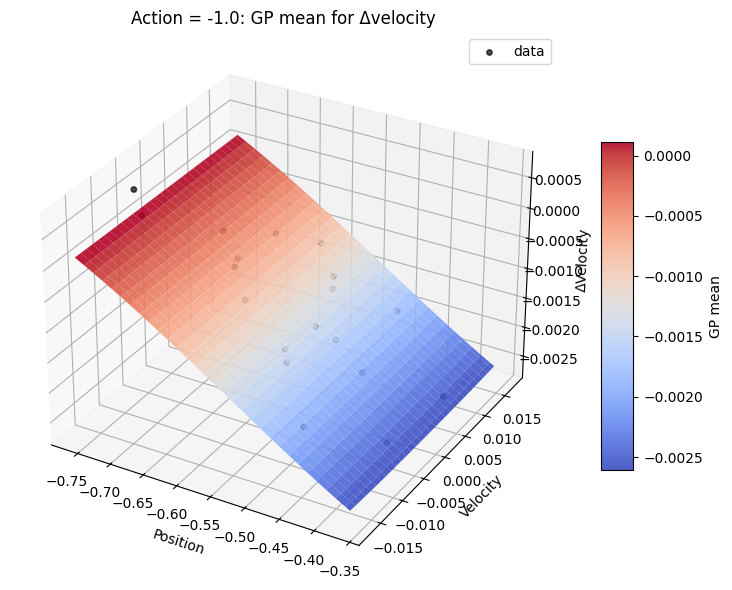

Plotting for action a=0.0
Values near action a=0.0 n=32


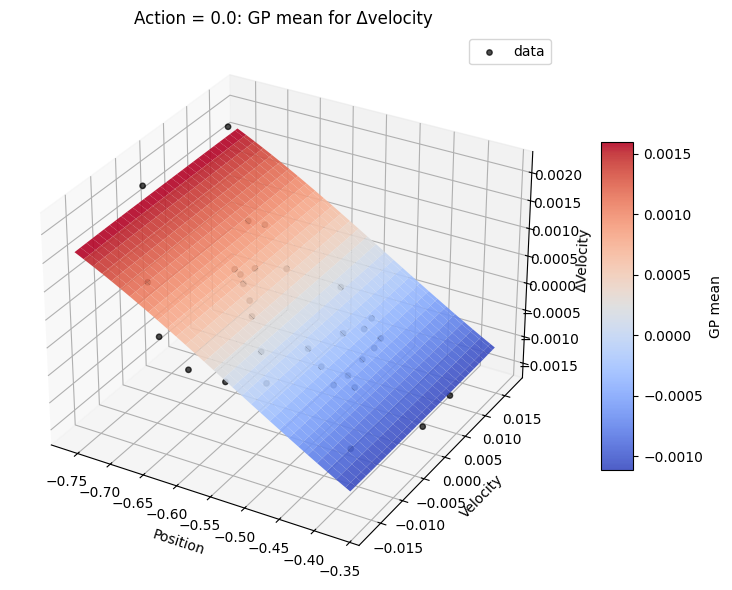

Plotting for action a=1.0
Values near action a=1.0 n=16


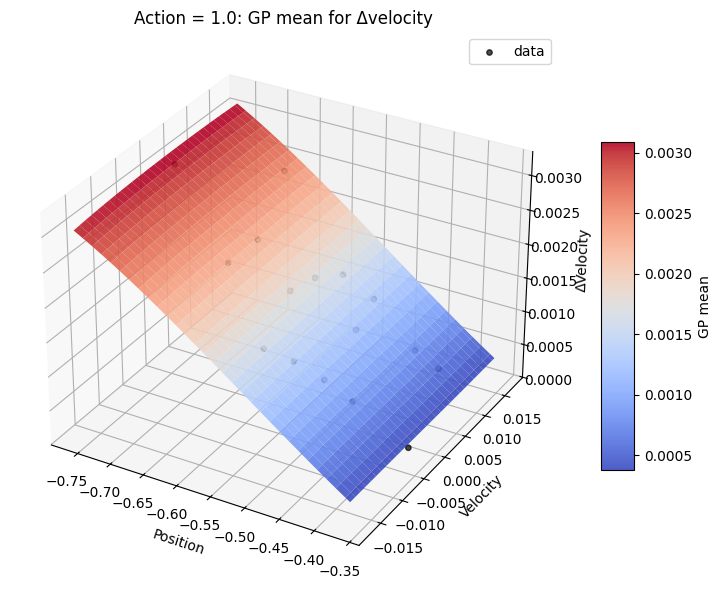

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity
a_values = [-1.0, 0.0, 1.0]  # representative actions

# Get raw training data
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train  # Δvelocity targets

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pos.min(), pos.max()
v_min, v_max = vel.min(), vel.max()

p_grid = np.linspace(p_min, p_max, 60)
v_grid = np.linspace(v_min, v_max, 60)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------
for a_fixed in a_values:
    print(f"Plotting for action a={a_fixed}")

    # Predict using the GP for this action
    X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])
    Mean, var = gp.predict(X_grid)
    Mean = Mean.reshape(P.shape)

    # --------------------------------------------------------
    # Plot as surface
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                           linewidth=0, antialiased=True, alpha=0.9)

    # Overlay training data close to this action value
    mask = np.abs(act - a_fixed) < 0.5
    print(f"Values near action a={a_fixed} n={np.sum(mask)}")
    ax.scatter(pos[mask], vel[mask], dvel[mask],
               color='k', s=15, alpha=0.7, label='data')

    # --------------------------------------------------------
    # Labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('ΔVelocity')
    ax.set_title(f"Action = {a_fixed:.1f}: GP mean for Δvelocity")

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


Values near action a=-1.0 → n=19


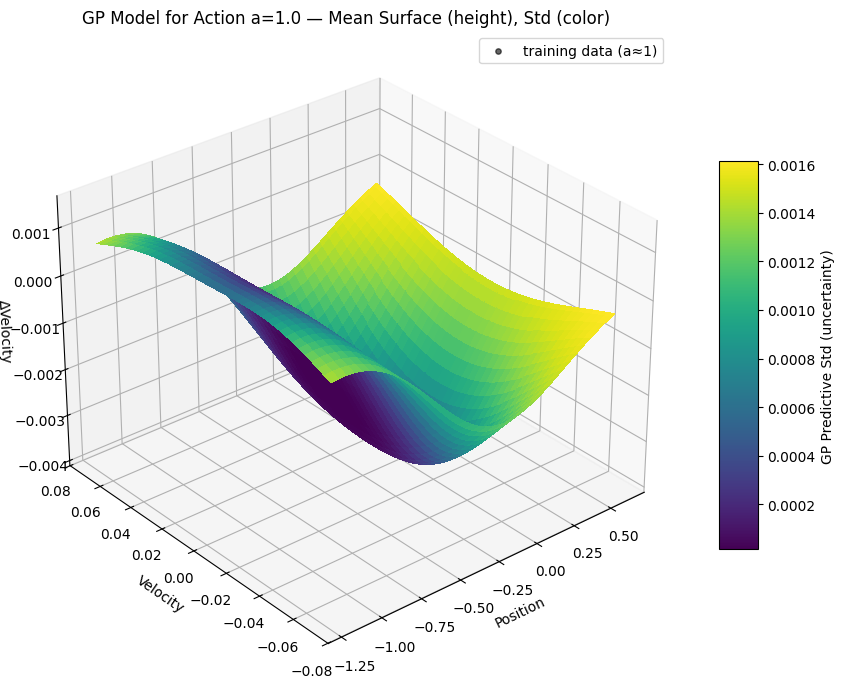

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity (index 0 for Δposition)
a_fixed = -1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train

# Select samples close to a=1 for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define position–velocity grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
v_min, v_max = -0.07, 0.07
p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action
X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])

# --------------------------------------------------------
# GP predictions
# --------------------------------------------------------
Mean, Var = gp.predict(X_grid)
Mean = Mean.reshape(P.shape)
Std = np.sqrt(Var.reshape(P.shape))

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors, linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pos[mask], vel[mask], dvel[mask],
    color='k', s=15, alpha=0.6, label='training data (a≈1)'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('ΔVelocity')
ax.set_title("GP Model for Action a=1.0 — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


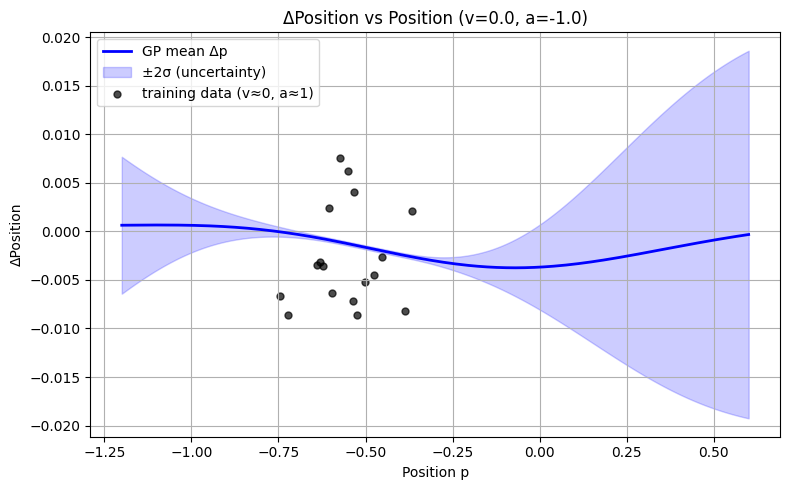

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: Δposition model
# --------------------------------------------------------
gp = gps[0]       # GP for Δposition
v_fixed = 0.0     # fix velocity
a_fixed = -1.0     # fix action

# --------------------------------------------------------
# Define position grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
p_grid = np.linspace(p_min, p_max, 200)

# Construct query points [p, v_fixed, a_fixed]
X_query = np.column_stack([p_grid, np.full_like(p_grid, v_fixed), np.full_like(p_grid, a_fixed)])

# --------------------------------------------------------
# Predict GP mean and std
# --------------------------------------------------------
Mean, Var = gp.predict(X_query)
Std = np.sqrt(Var)

# --------------------------------------------------------
# Plot mean ± std as shaded region
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(p_grid, Mean, 'b-', lw=2, label='GP mean Δp')
plt.fill_between(p_grid, Mean - 2*Std, Mean + 2*Std,
                 color='blue', alpha=0.2, label='±2σ (uncertainty)')

# --------------------------------------------------------
# Overlay training data near v=0 and a=1
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
mask = (np.abs(X_train[:, 1] - v_fixed) < 0.01) & (np.abs(X_train[:, 2] - a_fixed) < 0.5)
plt.scatter(X_train[mask, 0], Y_train[mask], color='k', s=25, alpha=0.7, label='training data (v≈0, a≈1)')

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
plt.xlabel("Position p")
plt.ylabel("ΔPosition")
plt.title(f"ΔPosition vs Position (v={v_fixed}, a={a_fixed})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Exercise 1
Use the trained GP as a learned dynamics model to control the Mountain Car environment using Model Predictive Control (MPC).

You can choose between:
* MPPI (Model Predictive Path Integral) – probabilistic trajectory weighting, or
* MPPI-Simplified (Random Shooting) – select the lowest-cost trajectory among random samples.

Your controller should plan ahead, predict future states using the GP, and drive the car to reach the goal in a single episode.

### Expected Outcome
By the end of the exercise, your controller should:
* Use the GP model to predict the system dynamics
* Plan and select optimal actions using MPC
* Drive the car to reach the goal in one episode

### Deliverables

* Your implementation of the mpc_action() function
* A plot showing the car’s position versus time
* A short explanation (2–3 sentences) describing how MBRL is more efficient than Q-learning.
* Describe the downside of MBRL over Q-learning

# MPC


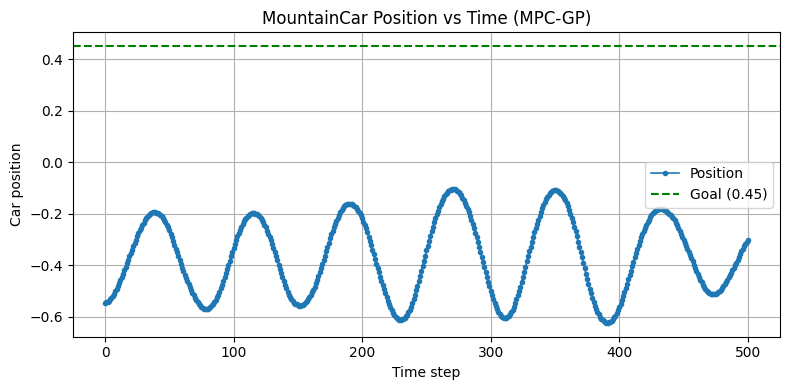

In [27]:
obs, info = env.reset(seed=0)
# Used gpt for debugging and correcting my syntax
def mpc_action(state, gps):
    horizon=15
    num_samples=600
    action_std=0.5
    action_lowest=-1.0
    action_highest=1.0
    goal_pos=0.45
    control_cost=1e-2

    A = np.random.normal(0.0, action_std, size=(num_samples, horizon))
    A = np.clip(A, action_lowest, action_highest)

    position = np.full((num_samples,), float(state[0]))
    velocity = np.full((num_samples,), float(state[1]))
    costs = np.zeros((num_samples,))

    for t in range(horizon):
        a_t = A[:, t]
        X_t = np.column_stack([position, velocity, a_t])
        delta_p, _ = gps[0].predict(X_t)
        delta_v, _ = gps[1].predict(X_t)
        position = np.clip(position + delta_p, -1.2, 0.6)
        velocity = np.clip(velocity + delta_v, -0.07, 0.07)
        costs += (position - goal_pos)**2 + control_cost * a_t**3

    best = np.argmin(costs)

    return float(A[best, 0])


obs, _ = env.reset()
state = np.array(obs, dtype=float)
positions = [state[0]]

for step in range(500):
    a = mpc_action(state, gps)
    next_obs, r, term, trunc, _ = env.step([a])
    state = np.array(next_obs, dtype=float)
    positions.append(state[0])
    if term or trunc or state[0] >= 0.45:
        break

# Used GPT For plotting

plt.figure(figsize=(8,4))
plt.plot(positions, '-o', markersize=3, linewidth=1.2, label='Position')
plt.axhline(0.45, linestyle='--', color='g', label='Goal (0.45)')
plt.xlabel("Time step")
plt.ylabel("Car position")
plt.title("MountainCar Position vs Time (MPC-GP)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Efficiency

It's good because we dont have to interact with the real environmwnt as much. Q-learning for example requires taking smaples from the environment at each step. MBRL on the other hand allows us to model environment dynamics and use this model instead of getting samples from the environment. So it is more effiecient because it requires less sampling when it learns.

# Downside
The downside is that if the model of the environment is bad then training on the bad learned dynamics will result in bad learning. Some environments are inherintly hard to model too which makes MBRL bad in those cases. Q-learning will usually do better in this case since it interacts with the environment each time.



# Exercise 2 (Graduate students)
Extend the MPC controller from Exercise 1 by incorporating Gaussian Process (GP) uncertainty into the MPPI algorithm.
The goal is to study how including the GP’s predictive variance affects control performance and sample efficiency.


* Include GP uncertainty (variance) in the MPPI algorithm.
Modify the cost function or trajectory weighting so that trajectories passing through regions of high model uncertainty are penalized.

* Compare two systems:
  * MPPI using only the GP mean prediction (deterministic model).
  * MPPI using both the GP mean and variance (uncertainty-aware model).
* Evaluate and discuss the results:
  * The MBRL system from Exercise 1 usually solves the Mountain Car problem in more than 100 steps, even after several episodes.
  * Investigate whether incorporating uncertainty can help the controller reach the goal faster or with fewer samples.
  * Provide plots of position over time for both cases.

## Deliverables

* Your modified MPPI implementation that includes GP variance.
* Two plots comparing:
    * Position vs. time (with and without variance)
    * Cumulative reward or number of steps to reach the goal
* A short discussion (2–3 paragraphs) explaining how including uncertainty affects performance and why it might lead to better results.

# Task
Implement a Model Predictive Control (MPC) strategy using Random Shooting to solve the Mountain Car problem. This involves defining a `cost_fn` that penalizes states far from the goal and negative velocity, and implementing a `predict_next_state_gp` function that uses the provided Gaussian Process (GP) models to predict future states. Then, create an `mpc_action` function that samples random action sequences, simulates trajectories with the GP model, and selects the first action from the sequence yielding the lowest cumulative cost. Run a simulation using this MPC controller to drive the car to the goal. Finally, plot the car's position over time and provide a short explanation (2–3 sentences) describing the efficiency of Model-Based Reinforcement Learning (MBRL) compared to Q-learning, as well as the downsides of MBRL.

## Define Cost Function

### Subtask:
Implement a cost function `cost_fn(state)` that evaluates how 'good' a given state is. For Mountain Car, this will typically penalize states far from the goal (position 0.5) and penalize negative velocity.


**Reasoning**:
Implement the `cost_fn` function as described, calculating penalties for position and negative velocity, and returning their sum.



In [8]:
def cost_fn(state):
    """
    Evaluates the cost of a given Mountain Car state.
    Penalizes states far from the goal position (0.5) and negative velocity.

    Args:
        state (np.ndarray): The current state [position, velocity].

    Returns:
        float: The total cost for the state.
    """
    position, velocity = state[0], state[1]

    # Penalty for being far from the goal position (0.5)
    goal_position = 0.5
    position_cost = (position - goal_position)**2

    # Penalty for negative velocity (discourages moving away from the goal once past the dip)
    # We want to encourage positive velocity to climb the right hill
    velocity_cost = 0
    if velocity < 0:
        velocity_cost = (-velocity)**2 # or abs(velocity) or max(0, -velocity)

    # Combine costs (you might need to tune weights)
    total_cost = position_cost + 10 * velocity_cost # Increased weight for velocity cost

    return total_cost

print("Cost function `cost_fn` defined.")

Cost function `cost_fn` defined.


## Predict Next State with GP

### Subtask:
Implement a function `predict_next_state_gp(current_state, action)` that uses the trained Gaussian Process (GP) models (`gps[0]` for $\Delta$position and `gps[1]` for $\Delta$velocity) to predict the next state of the Mountain Car environment. This function should integrate the predicted state changes ($\Delta$position and $\Delta$velocity) with the `current_state` to estimate the `next_state`.

#### Instructions:
1. Define a Python function named `predict_next_state_gp` that takes `current_state` (a NumPy array of `[position, velocity]`) and `action` (a float) as input.
2. Concatenate the `current_state` and `action` to form the input for the GP models: `X_gp = np.array([position, velocity, action])`.
3. Use `gps[0].predict(X_gp.reshape(1, -1))` to get the predicted $\Delta$position (mean of the prediction).
4. Use `gps[1].predict(X_gp.reshape(1, -1))` to get the predicted $\Delta$velocity (mean of the prediction).
5. Add the predicted $\Delta$position to the `current_state[0]` to get the new position.
6. Add the predicted $\Delta$velocity to the `current_state[1]` to get the new velocity.
7. Return the `next_state` as a NumPy array `[new_position, new_velocity]`.
8. Remember to clamp the predicted next state values to the environment's bounds (position between -1.2 and 0.6, velocity between -0.07 and 0.07) to ensure physical realism. `env.observation_space.low` and `env.observation_space.high` can provide these bounds.

**Reasoning**:
Now I will implement the `predict_next_state_gp` function as described in the instructions, using the trained Gaussian Process models and clamping the output to environment bounds.



In [9]:
def predict_next_state_gp(current_state, action):
    """
    Predicts the next state using the trained Gaussian Process models.

    Args:
        current_state (np.ndarray): The current state [position, velocity].
        action (float): The action to apply.

    Returns:
        np.ndarray: The predicted next state [new_position, new_velocity].
    """
    # 1. Concatenate current_state and action for GP input
    X_gp = np.concatenate([current_state, [action]])

    # 2. Predict Delta Position using gps[0]
    delta_pos_mean, _ = gps[0].predict(X_gp.reshape(1, -1))
    delta_position = delta_pos_mean[0]

    # 3. Predict Delta Velocity using gps[1]
    delta_vel_mean, _ = gps[1].predict(X_gp.reshape(1, -1))
    delta_velocity = delta_vel_mean[0]

    # 4. Calculate the new state
    new_position = current_state[0] + delta_position
    new_velocity = current_state[1] + delta_velocity

    # 5. Clamp the predicted next state values to environment bounds
    min_pos, max_pos = env.observation_space.low[0], env.observation_space.high[0]
    min_vel, max_vel = env.observation_space.low[1], env.observation_space.high[1]

    new_position = np.clip(new_position, min_pos, max_pos)
    new_velocity = np.clip(new_velocity, min_vel, max_vel)

    next_state = np.array([new_position, new_velocity])

    return next_state

print("Function `predict_next_state_gp` defined.")

Function `predict_next_state_gp` defined.


## Implement MPC with Random Shooting

### Subtask:
Implement the `mpc_action(current_state, num_samples, horizon, action_space)` function that determines the best action to take using the Random Shooting MPC algorithm.

#### Instructions:
1.  Define a Python function named `mpc_action` that takes `current_state`, `num_samples` (number of random action sequences to sample), `horizon` (number of future steps to predict), and `action_space` (the environment's action space) as input.
2.  Initialize `best_action_sequence` and `min_total_cost` to track the best found sequence and its cost.
3.  Loop `num_samples` times:
    a.  For each sample, generate a random action sequence of length `horizon`. Each action should be sampled from the `action_space.sample()` method.
    b.  Initialize `trajectory_cost = 0` and `simulated_state = current_state.copy()`.
    c.  Simulate the trajectory over the `horizon` using `predict_next_state_gp`:
        i.  For each action in the `random_action_sequence`:
            *   Predict the `next_state` using `predict_next_state_gp(simulated_state, action)`.
            *   Calculate the `cost` for the `next_state` using `cost_fn(next_state)`.
            *   Add the `cost` to `trajectory_cost`.
            *   Update `simulated_state = next_state`.
    d.  After simulating the entire trajectory, compare `trajectory_cost` with `min_total_cost`. If `trajectory_cost` is lower, update `min_total_cost` and `best_action_sequence`.
4.  Return the first action from the `best_action_sequence`. If no sequences were found (e.g., if `num_samples` is 0), return a default action (e.g., `action_space.sample()` or 0).

**Reasoning**:
Now I will implement the `mpc_action` function as described in the instructions, which uses the `predict_next_state_gp` and `cost_fn` to find the optimal first action through random shooting.



In [10]:
def mpc_action(current_state, num_samples, horizon, action_space):
    """
    Determines the best action to take using the Random Shooting MPC algorithm.

    Args:
        current_state (np.ndarray): The current state [position, velocity].
        num_samples (int): Number of random action sequences to sample.
        horizon (int): Number of future steps to predict.
        action_space (gym.spaces.Box): The environment's action space.

    Returns:
        float: The first action from the best action sequence.
    """
    best_action_sequence = None
    min_total_cost = float('inf')

    for _ in range(num_samples):
        random_action_sequence = []
        # Generate a random action sequence for the given horizon
        for _ in range(horizon):
            random_action_sequence.append(action_space.sample()[0]) # [0] to get the scalar from Box(1,)

        trajectory_cost = 0.0
        simulated_state = current_state.copy()

        # Simulate the trajectory using the GP model
        for action in random_action_sequence:
            next_state = predict_next_state_gp(simulated_state, action)
            trajectory_cost += cost_fn(next_state)
            simulated_state = next_state

        # Update best sequence if current one is better
        if trajectory_cost < min_total_cost:
            min_total_cost = trajectory_cost
            best_action_sequence = random_action_sequence

    if best_action_sequence is None:
        # Fallback if no samples were run (e.g., num_samples=0) or an issue
        return action_space.sample()[0] # Return a random action as default

    return best_action_sequence[0]

print("Function `mpc_action` defined.")

Function `mpc_action` defined.


**Reasoning**:
With all helper functions (`cost_fn`, `predict_next_state_gp`, `mpc_action`) now defined, I will proceed to run the simulation using the MPC controller. This involves setting up the environment, looping through steps, collecting position data, and applying the `mpc_action` to drive the car.



In [11]:
import matplotlib.pyplot as plt

# --- Simulation Parameters ---
NUM_SAMPLES = 500  # Number of random action sequences to sample
HORIZON = 10     # Number of future steps to predict
MAX_STEPS = 500  # Maximum steps per episode

# --- Simulation Loop ---
current_state, _ = env.reset(seed=42) # Reset environment for a reproducible run
positions = [current_state[0]]
velocities = [current_state[1]]
rewards = []

print("Starting MPC simulation...")
for step in range(MAX_STEPS):
    # Get action from MPC controller
    action = mpc_action(current_state, NUM_SAMPLES, HORIZON, env.action_space)

    # Apply action to the environment
    next_state, reward, terminated, truncated, _ = env.step(np.array([action]))

    # Store results
    positions.append(next_state[0])
    velocities.append(next_state[1])
    rewards.append(reward)
    current_state = next_state

    if terminated or truncated:
        print(f"Episode finished after {step + 1} steps.")
        break

print("MPC simulation finished.")


Starting MPC simulation...


KeyboardInterrupt: 